# NVAE Debug Experiment with WandB & Overfitting Check

This debug notebook tests:
1. **WandB Logging**: Ensures metrics and images are logged correctly.
2. **Overfitting**: Uses the training set as the validation set to verify the model can learn.
3. **Config**: 10 Epochs, Subset of data.

## 1. Google Colab Setup
Mount Drive and clone the repository (Fresh Copy).

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Generative-Modeling-on-CIFAR-10'
REPO_URL = "https://github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

# 1. Delete repo if it already exists (Ensure fresh code)
if os.path.exists(REPO_PATH):
    print(f"Deleting existing repository at {REPO_PATH}...")
    shutil.rmtree(REPO_PATH)

# 2. Clone repository
os.chdir('/content/drive/MyDrive')
print(f"Cloning repository to {REPO_PATH}...")
!git clone {REPO_URL}

# 3. Enter the repository
os.chdir(REPO_PATH)
print(f"Current working directory: {os.getcwd()}")

# 4. Add source code to Python path
sys.path.append(os.path.join(REPO_PATH, 'src'))

Mounted at /content/drive
Deleting existing repository at /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning repository to /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning into 'Generative-Modeling-on-CIFAR-10'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 98 (delta 30), reused 48 (delta 15), pack-reused 33 (from 1)
Receiving objects: 100% (98/98), 211.95 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (31/31), done.
Current working directory: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10


## 2. GitHub & WandB Configuration
**Important:** You need your WandB API key here.

In [2]:
# GitHub Configuration & Setup
import os

try:
    # 1. Configure Git
    user_name = "konstantine25b"
    mail = "konstantine25b@gmail.com"

    # --- IMPORTANT: PASTE YOUR TOKEN BELOW ---
    my_token = "YOUR_TOKEN_HERE"

    if my_token == "YOUR_TOKEN_HERE":
        print("⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.")

    repo_url = f"https://{my_token}@github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

    !git config --global user.name "{user_name}"
    !git config --global user.email "{mail}"

    # 2. Set Remote URL
    if os.path.isdir(".git") and my_token != "YOUR_TOKEN_HERE":
        !git remote set-url origin "{repo_url}"
        print("Git configured successfully for pushing.")
    else:
        print("Skipping remote setup (either not a git repo or token not set).")

except Exception as e:
    print(f"Error setting up GitHub: {e}")

⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.
Skipping remote setup (either not a git repo or token not set).


## 3. Install Dependencies

In [3]:
!pip install -r requirements.txt
!pip install wandb -q

# Login to WandB
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 4. Setup WandB Test Experiment

In [4]:
import torch
from src.utils.data_loader import get_cifar10_loaders
from src.vae.train import train_vae
from src.vae.sampling import generate_samples, save_sample_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# WandB Test Configuration
config = {
    'epochs': 10,         # Increased to 10
    'batch_size': 64,
    'lr': 1e-3,
    'hidden_dim': 64,
    'latent_dim': 20,
    'num_scales': 2,
    'warmup_epochs': 3,
    'weight_decay': 3e-4,
    'use_wandb': True,    # ENABLED WandB
    'run_name': 'nvae_debug_wandb_test',
    'model_save_dir': 'models/debug_wandb',
    'results_dir': 'results/debug_wandb'
}

# Create directories
os.makedirs(config['model_save_dir'], exist_ok=True)
os.makedirs(config['results_dir'], exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5. Load Data (Train set used as Val set)
We use a subset of the training data for both training AND validation to check for overfitting.

In [5]:
from torch.utils.data import DataLoader, Subset

full_train_loader, _, _ = get_cifar10_loaders(
    data_dir='./data',
    batch_size=config['batch_size']
)

# Create a small subset of training data (e.g., 2000 images)
def create_subset_loader(original_loader, size=2000):
    dataset = original_loader.dataset
    indices = list(range(size))
    subset = Subset(dataset, indices)

    return DataLoader(
        subset,
        batch_size=original_loader.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

# Create ONE subset loader
subset_loader = create_subset_loader(full_train_loader, size=5000)

# Use the SAME loader for both Train and Test to check overfitting capability
train_loader = subset_loader
val_loader = subset_loader

print(f"Using same subset ({len(train_loader.dataset)} images) for Train and Val.")

Data Loaders ready: Train=45000, Val=5000, Test=10000
Using same subset (5000 images) for Train and Val.


## 6. Train Model (WandB Enabled)

In [6]:
# Start Training
train_vae(config, train_loader, val_loader, device)

Model initialized on cuda


Epoch 1/10: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s, loss=1924.38, bpd=0.90, beta=0.33]


=== Epoch 1 Summary ===
Train Loss: 1890.3636 | Recon: 1842.0909 | KL: 144.8180 | BPD: 0.8878


Val Loss:   2053.9458 | Val BPD: 0.9646
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 2053.9458)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_1.pth


Epoch 2/10: 100%|██████████| 79/79 [00:10<00:00,  7.74it/s, loss=1913.33, bpd=0.90, beta=0.67]


=== Epoch 2 Summary ===
Train Loss: 1857.5717 | Recon: 1809.6722 | KL: 71.8492 | BPD: 0.8724


Val Loss:   1868.4496 | Val BPD: 0.8775
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1868.4496)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_2.pth


Epoch 3/10: 100%|██████████| 79/79 [00:09<00:00,  7.97it/s, loss=1632.40, bpd=0.77, beta=1.00]


=== Epoch 3 Summary ===
Train Loss: 1855.1221 | Recon: 1802.8323 | KL: 52.2898 | BPD: 0.8712


Val Loss:   1852.3120 | Val BPD: 0.8699
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1852.3120)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_3.pth


Epoch 4/10: 100%|██████████| 79/79 [00:10<00:00,  7.89it/s, loss=1830.91, bpd=0.86, beta=1.00]


=== Epoch 4 Summary ===
Train Loss: 1853.3667 | Recon: 1803.6547 | KL: 49.7120 | BPD: 0.8704


Val Loss:   1852.3711 | Val BPD: 0.8699
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_4.pth


Epoch 5/10: 100%|██████████| 79/79 [00:09<00:00,  7.94it/s, loss=1849.68, bpd=0.87, beta=1.00]


=== Epoch 5 Summary ===
Train Loss: 1850.4516 | Recon: 1800.7774 | KL: 49.6741 | BPD: 0.8690


Val Loss:   1853.3103 | Val BPD: 0.8704
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_5.pth


Epoch 6/10: 100%|██████████| 79/79 [00:09<00:00,  8.04it/s, loss=1768.76, bpd=0.83, beta=1.00]


=== Epoch 6 Summary ===
Train Loss: 1846.3614 | Recon: 1797.4528 | KL: 48.9086 | BPD: 0.8671


Val Loss:   1847.1108 | Val BPD: 0.8675
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1847.1108)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_6.pth


Epoch 7/10: 100%|██████████| 79/79 [00:09<00:00,  7.94it/s, loss=1935.79, bpd=0.91, beta=1.00]


=== Epoch 7 Summary ===
Train Loss: 1846.0144 | Recon: 1797.1258 | KL: 48.8886 | BPD: 0.8669


Val Loss:   1846.1828 | Val BPD: 0.8670
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1846.1828)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_7.pth


Epoch 8/10: 100%|██████████| 79/79 [00:09<00:00,  8.09it/s, loss=1869.91, bpd=0.88, beta=1.00]


=== Epoch 8 Summary ===
Train Loss: 1844.1256 | Recon: 1795.2216 | KL: 48.9041 | BPD: 0.8661


Val Loss:   1839.3997 | Val BPD: 0.8638
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1839.3997)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_8.pth


Epoch 9/10: 100%|██████████| 79/79 [00:09<00:00,  8.20it/s, loss=1968.10, bpd=0.92, beta=1.00]


=== Epoch 9 Summary ===
Train Loss: 1843.7357 | Recon: 1795.0791 | KL: 48.6566 | BPD: 0.8659


Val Loss:   1839.5053 | Val BPD: 0.8639
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_9.pth


Epoch 10/10: 100%|██████████| 79/79 [00:09<00:00,  8.21it/s, loss=1963.34, bpd=0.92, beta=1.00]


=== Epoch 10 Summary ===
Train Loss: 1843.2187 | Recon: 1794.3828 | KL: 48.8358 | BPD: 0.8656


Val Loss:   1837.1760 | Val BPD: 0.8628
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 1837.1760)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_10.pth


## 7. Generate Samples & Log to WandB

Loaded best model.


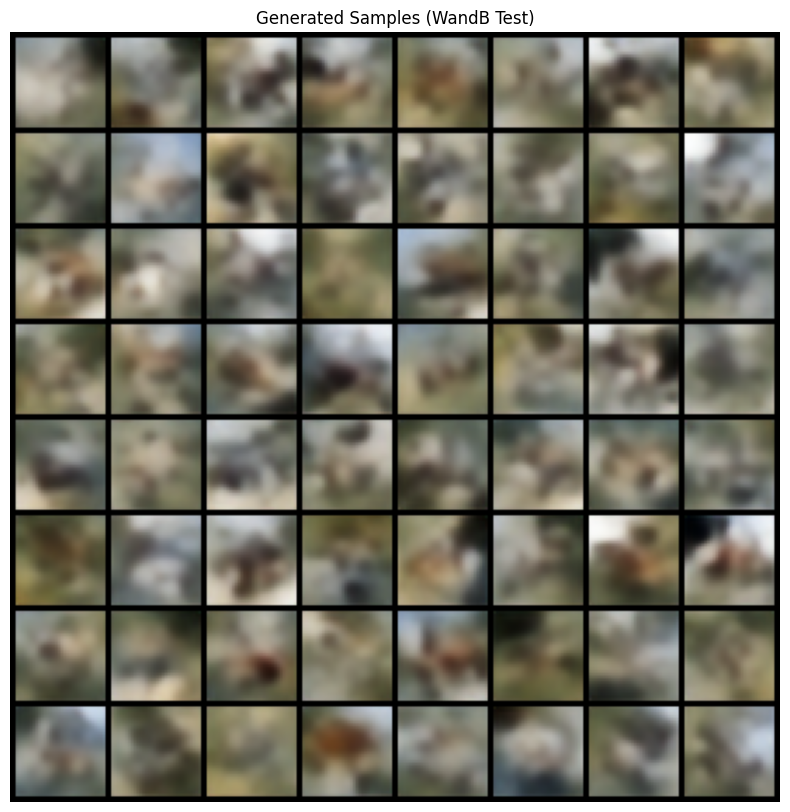

Logged final samples to WandB.


epoch,▁▂▃▃▄▅▆▆▇█
train/beta,▁▅████████
train/bpd,█▃▃▃▂▁▁▁▁▁
train/kl,█▃▁▁▁▁▁▁▁▁
train/loss,█▃▃▃▂▁▁▁▁▁
train/lr,██▇▇▆▄▃▂▂▁
train/recon,█▃▂▂▂▁▁▁▁▁
train/step_bpd,█▁▁▁▁▂▁▂▂▂
train/step_kl,█▂▁▁▁▁▁▁▁▁
train/step_loss,█▁▁▁▁▂▁▂▂▂
+3,...


In [7]:
# Load best model
from src.vae.model import NVAE
import torchvision.utils as vutils

model = NVAE(
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    num_scales=config['num_scales']
).to(device)

model.load_state_dict(torch.load(os.path.join(config['model_save_dir'], 'nvae_best.pth')))
print("Loaded best model.")

# Generate
samples = generate_samples(model, num_samples=64, temperature=0.8, device=device)

# Visualize locally
plt.figure(figsize=(10, 10))
grid_img = vutils.make_grid(samples, nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Generated Samples (WandB Test)")
plt.show()

# Log to WandB if active
if wandb.run is not None:
    wandb.log({
        "final_evaluation/generated_samples_grid": [wandb.Image(grid_img, caption="Final Generated Samples (T=0.8)")]
    })
    print("Logged final samples to WandB.")
    wandb.finish()